# Financial Fraud Detection using Neuro-Symbolic AI Approach

## Neural Network with Logic-based Rules

---

**What is Neuro-Symbolic AI?**

- It is an approach to artificial intelligence that combines deep learning (neural networks) with symbolic reasoning to improve performance and overcome limitations of each method.
- This hybrid approach aims to leverage the pattern recognition and learning capabilities of neural networks with the logical, explainable, and structured reasoning of symbolic systems.

TL;DR: *Neuro-Symbolic = AI + Symbolic Reasoning*

**Benefits of this approach**:
- Improved Reasoning and Accuracy
- Enhanced Explainability
- Addressing Limitations of Large Language Models (LLMs)
- Efficient Learning
- Key Application Areas

---

In [ ]:
from __future__ import annotations
from dataclasses import dataclass
from typing import Tuple, List, Dict
import warnings
warnings.filterwarnings("ignore")

# Data manipulations
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, classification_report
from sklearn.utils import check_random_state

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')

print('All libraries are imported successfully.')

All libraries are imported successfully.


### Set up configurations for the model

In [ ]:
@dataclass(frozen=True)
class Config:

  # Input Data
  csv_path: str = "/content/synthetic_financial_dataset.csv"
  sample_rows: int = 25000
  random_state: int = 42
  test_size: float = 0.20
  val_size: float = 0.20          # For training the combiner

  # Business Logic
  illegal_transfer_threshold: float = 200_000.0
  epsilon_balance: float = 1e-3   # Tolerance for balance mismatch

  # Neural Network
  max_iter_mlp: int = 60          # Can decrease for fast training
  hidden_layers: tuple = (24, 12) # Compact architecture
  class_weight: str | None = None

cfg = Config()

print(f"📋 Configuration loaded:")
print(f".  - Sample Size: {cfg.sample_rows:,} rows")
print(f".  - Illegal Transfer Threshold: ${cfg.illegal_transfer_threshold:,.0f}")
print(f"   - Neural network: {cfg.hidden_layers} hidden layers")

📋 Configuration loaded:
.  - Sample Size: 25,000 rows
.  - Illegal Transfer Threshold: $200,000
   - Neural network: (24, 12) hidden layers


In [ ]:
def load_data(cfg: Config) -> pd.DataFrame:
  """Load and process input dataset."""

  df = pd.read_csv(cfg.csv_path)

  # Essential columns for fraud detection
  needed = [
      'step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
      'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud', 'isFlaggedFraud'
  ]

  missing = set(needed) - set(df.columns)
  if missing:
    raise ValueError(f"Missing columns: {sorted(missing)}")

  # Stratified sampling to maintain class balance
  if cfg.sample_rows and cfg.sample_rows < len(df):
    random_num_gen = check_random_state(cfg.random_state)

    # Keep balanced class representation
    fraud_idx = df[df['isFraud'] == 1].index.values
    legit_idx = df[df['isFraud'] != 1].index.values

    take_fraud = min(len(fraud_idx), cfg.sample_rows // 10)
    take_legit = cfg.sample_rows - take_fraud

    fraud_sample = random_num_gen.choice(fraud_idx, size=take_fraud, replace=False)
    legit_sample = random_num_gen.choice(legit_idx, size=take_legit, replace=False)

    df = df.loc[np.concatenate([fraud_sample, legit_sample])]
    df = df.sample(frac=1, random_state=cfg.random_state) # Shuffle data

  return df.reset_index(drop=True)

# Load the data
df = load_data(cfg)

print(f"📊 Loaded dataset successfully.")
print(f"   - Total Transactions: {len(df):,}")
print(f"   - Fradulent: {df['isFraud'].sum():,} ({df['isFraud'].mean()*100:.2f}%)")
print(f"   - Legitimate: {(~df['isFraud'].astype(bool)).sum():,} ({(1-df['isFraud'].mean())*100:.2f}%)")

print("\n📈 Transaction types distribution:")
print(df['type'].value_counts())

📊 Loaded dataset successfully.
   - Total Transactions: 25,000
   - Fradulent: 2,500.0 (10.00%)
   - Legitimate: 22,500 (90.00%)

📈 Transaction types distribution:
type
CASH_OUT    9312
PAYMENT     7457
CASH_IN     4949
TRANSFER    3122
DEBIT        160
Name: count, dtype: int64


### Exploratory Data Analysis

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,162,DEBIT,4235.69,C1920969650,119670.00,115434.31,C5219415,185108.55,189344.24,0.0,0.0
1,36,PAYMENT,3136.78,C955276916,0.00,0.00,M1463192185,0.00,0.00,0.0,0.0
2,16,PAYMENT,6094.38,C948411963,378187.46,372093.08,M1523359040,0.00,0.00,0.0,0.0
3,212,PAYMENT,4409.89,C2070498625,51244.00,46834.11,M2107084156,0.00,0.00,0.0,0.0
4,184,PAYMENT,626.36,C199355764,7089.00,6462.64,M1949708481,0.00,0.00,0.0,0.0


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,25000.000000,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,25000.000000,25000.000000
mean,127.082160,2.688803e+05,8.826974e+05,7.759000e+05,9.644758e+05,1.125526e+06,0.100000,0.000040
std,76.867161,7.796576e+05,2.835397e+06,2.778588e+06,2.297848e+06,2.437227e+06,0.300006,0.006325
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,40.000000,1.455901e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,145.000000,9.309632e+04,2.085700e+04,0.000000e+00,9.823574e+04,2.144734e+05,0.000000,0.000000
75%,188.000000,2.425131e+05,1.999054e+05,1.141517e+05,8.774865e+05,1.139295e+06,0.000000,0.000000
max,236.000000,1.000000e+07,3.767004e+07,3.371395e+07,3.334870e+07,3.464570e+07,1.000000,1.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            25000 non-null  int64  
 1   type            25000 non-null  object 
 2   amount          25000 non-null  float64
 3   nameOrig        25000 non-null  object 
 4   oldbalanceOrg   25000 non-null  float64
 5   newbalanceOrig  25000 non-null  float64
 6   nameDest        25000 non-null  object 
 7   oldbalanceDest  25000 non-null  float64
 8   newbalanceDest  25000 non-null  float64
 9   isFraud         25000 non-null  float64
 10  isFlaggedFraud  25000 non-null  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 2.1+ MB


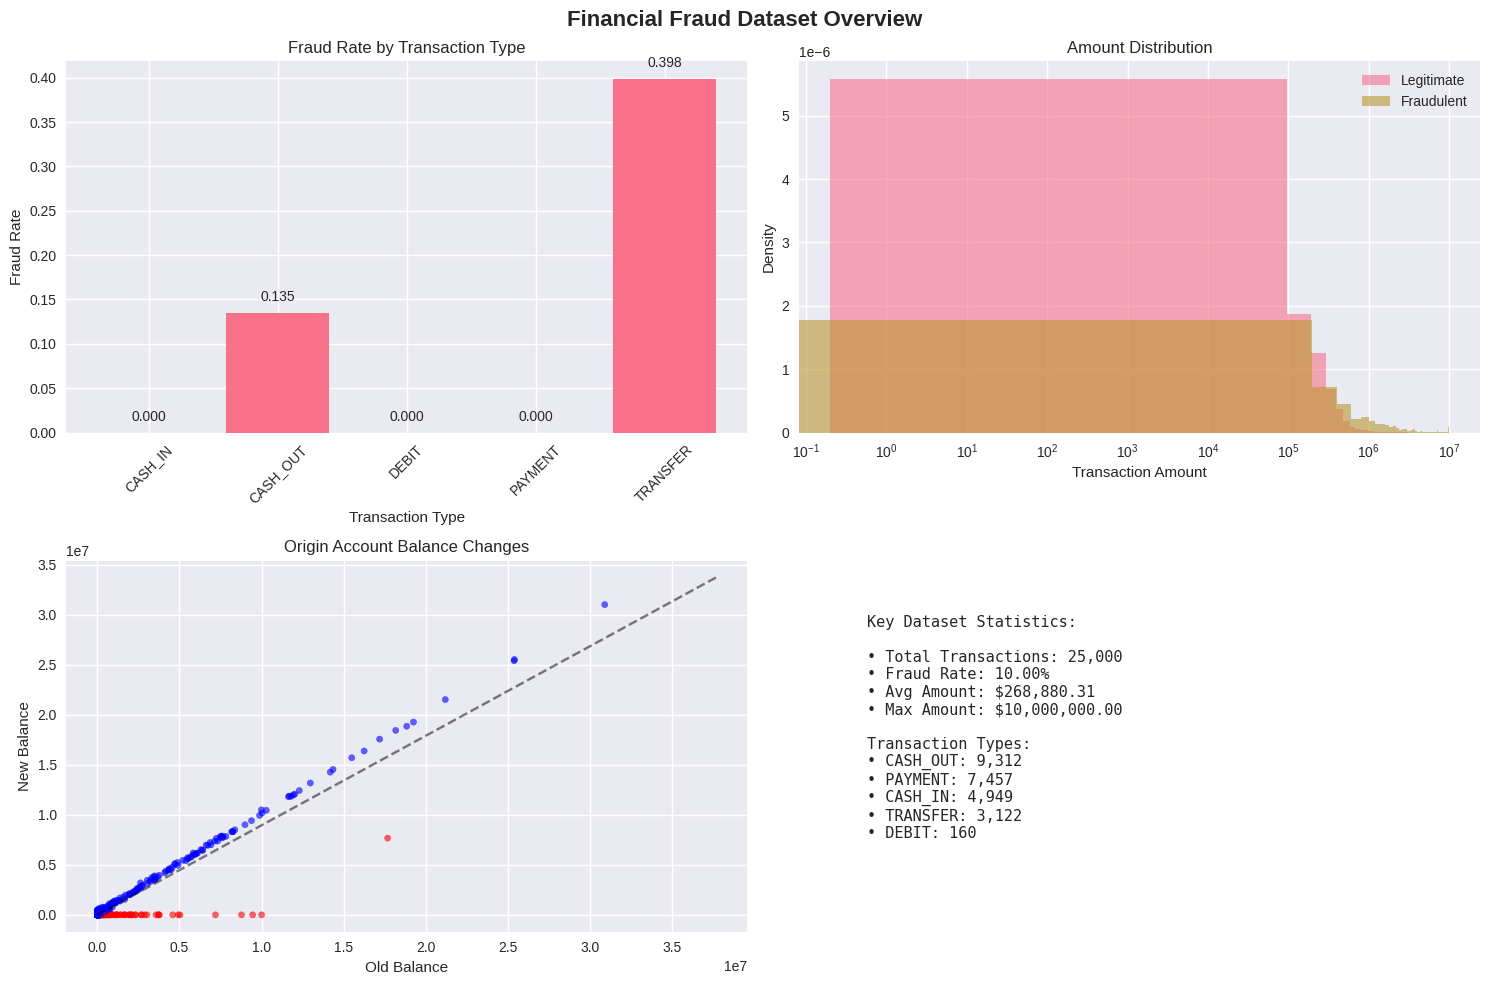

🔍 Key Insights:
   - TRANSFER and CASH_OUT have higher fraud rates
   - Fraudulent transactions often have suspicious balance patterns
   - Amount alone isn't a strong fraud indicator


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Financial Fraud Dataset Overview', fontsize=16, fontweight='bold')

# 1. Fraud by transaction type
fraud_by_type = df.groupby('type')['isFraud'].agg(['count', 'sum']).reset_index()
fraud_by_type['fraud_rate'] = fraud_by_type['sum'] / fraud_by_type['count']

bars = axes[0,0].bar(fraud_by_type['type'], fraud_by_type['fraud_rate'])
axes[0,0].set_title('Fraud Rate by Transaction Type')
axes[0,0].set_xlabel('Transaction Type')
axes[0,0].set_ylabel('Fraud Rate')
axes[0,0].tick_params(axis='x', rotation=45)
for i, bar in enumerate(bars):
  height = bar.get_height()
  axes[0,0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')

# 2. Amount distribution
axes[0,1].hist(df[df['isFraud']==0]['amount'], bins=50, alpha=0.6, label='Legitimate', density=True)
axes[0,1].hist(df[df['isFraud']==1]['amount'], bins=50, alpha=0.6, label='Fraudulent', density=True)
axes[0,1].set_title('Amount Distribution')
axes[0,1].set_xlabel('Transaction Amount')
axes[0,1].set_ylabel('Density')
axes[0,1].legend()
axes[0,1].set_xscale('log')

# 3. Account Balance changes
df_sample = df.sample(1000, random_state=42)
colors = ['red' if f == 1 else 'blue' for f in df_sample['isFraud']]
axes[1,0].scatter(df_sample['oldbalanceOrg'], df_sample['newbalanceOrig'], c=colors, alpha=0.6, s=20)
axes[1,0].set_title('Origin Account Balance Changes')
axes[1,0].set_xlabel('Old Balance')
axes[1,0].set_ylabel('New Balance')
axes[1,0].plot([0, df['oldbalanceOrg'].max()], [0, df['newbalanceOrig'].max()], 'k--', alpha=0.5)

# 4. Key statistics
axes[1,1].axis('off')
stats_text = f"""
Key Dataset Statistics:

• Total Transactions: {len(df):,}
• Fraud Rate: {df['isFraud'].mean()*100:.2f}%
• Avg Amount: ${df['amount'].mean():,.2f}
• Max Amount: ${df['amount'].max():,.2f}

Transaction Types:
• CASH_OUT: {(df['type']=='CASH_OUT').sum():,}
• PAYMENT: {(df['type']=='PAYMENT').sum():,}
• CASH_IN: {(df['type']=='CASH_IN').sum():,}
• TRANSFER: {(df['type']=='TRANSFER').sum():,}
• DEBIT: {(df['type']=='DEBIT').sum():,}
"""
axes[1,1].text(0.1, 0.9, stats_text, transform=axes[1,1].transAxes,
              fontsize=11, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print("🔍 Key Insights:")
print("   - TRANSFER and CASH_OUT have higher fraud rates")
print("   - Fraudulent transactions often have suspicious balance patterns")
print("   - Amount alone isn't a strong fraud indicator")

### Feature Engineering & Selection

In [ ]:
def engineer_features(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame]:
  """
  Engineer features for both the NN and symbolic rules.

  Returns:
    X_raw: Features before preprocessing (readable for rules)
    y: Target variable (fraud labels)
    X_ids: Identifier columns for explanations
  """

  X = df.copy()

  # Rule-friendly derived features
  X['is_merchant_dest'] = X['nameDest'].astype(str).str.startswith("M").astype(int)
  X['is_transfer'] = (X['type'] == 'TRANSFER').astype(int)
  X['is_cashout'] = (X['type'] == 'CASH_OUT').astype(int)

  # Balance consistency checks
  X['delta_orig'] = (X['newbalanceOrig'] - X['oldbalanceOrg']) - X['amount']
  X['delta_dest'] = (X['newbalanceDest'] - X['oldbalanceDest']) - X['amount']
  X['abs_delta_orig'] = X['delta_orig'].abs()
  X['abs_delta_dest'] = X['delta_dest'].abs()

  # Risk ratios
  X['amount_over_orig'] = X['amount'] / (X['oldbalanceOrg'].replace(0, np.nan))
  X['amount_over_orig'] = X['amount_over_orig'].fillna(0).clip(0, 100)

  # Features for ML Model
  ml_cols_num = [
      'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
      'oldbalanceDest', 'newbalanceDest',
      'abs_delta_orig', 'abs_delta_dest',
      'amount_over_orig', 'is_merchant_dest', 'is_transfer', 'is_cashout'
  ]
  ml_cols_cat = ['type']

  X_raw = X[ml_cols_num + ml_cols_cat].copy()
  y = X['isFraud'].astype(int).copy()
  X_ids = X[['nameOrig', 'nameDest', 'isFlaggedFraud']].copy()

  return X_raw, y, X_ids

# Engineer features
X_raw, y, X_ids = engineer_features(df)

print(f"🔧 Feature engineering completed.")
print(f".  - Features Created: {len(X_raw.columns)} total")
print(f".  - Numerical Created: {len([c for c in X_raw.columns if X_raw[c].dtype != 'object'])}")
print(f".  - Categorical Created: {len([c for c in X_raw.columns if X_raw[c].dtype == 'object'])}")

# Show sample of engineered features
print("\n📋 Sample of engineered features:")
display(X_raw.head())

🔧 Feature engineering completed.
.  - Features Created: 13 total
.  - Numerical Created: 12
.  - Categorical Created: 1

📋 Sample of engineered features:


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,abs_delta_orig,abs_delta_dest,amount_over_orig,is_merchant_dest,is_transfer,is_cashout,type
0,162,4235.69,119670.00,115434.31,185108.55,189344.24,8471.38,2.728484e-12,0.035395,0,0,0,DEBIT
1,36,3136.78,0.00,0.00,0.00,0.00,3136.78,3.136780e+03,0.000000,1,0,0,PAYMENT
2,16,6094.38,378187.46,372093.08,0.00,0.00,12188.76,6.094380e+03,0.016115,1,0,0,PAYMENT
3,212,4409.89,51244.00,46834.11,0.00,0.00,8819.78,4.409890e+03,0.086057,1,0,0,PAYMENT
4,184,626.36,7089.00,6462.64,0.00,0.00,1252.72,6.263600e+02,0.088357,1,0,0,PAYMENT


### Part 1: Traditional Neural Network Approach

In [ ]:
def build_nn_pipeline(num_cols: List[str], cat_cols: List[str], cfg: Config) -> Pipeline:
  """Build a neural network pipeline with preprocessing."""

  # Preprocessing Pipeline
  preprocessor = ColumnTransformer(
      transformers=[
          ('scaler', StandardScaler(), num_cols),
          ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
      ])

  # Neural Network
  mlp = MLPClassifier(
      hidden_layer_sizes=cfg.hidden_layers,
      activation='relu',
      solver='adam',
      alpha=1e-4,
      learning_rate_init=1e-3,
      max_iter=cfg.max_iter_mlp,
      early_stopping=True,
      validation_fraction=0.15,
      n_iter_no_change=10,
      random_state=cfg.random_state
  )

  # Combined Pipeline
  pipeline = Pipeline([
      ('preprocess', preprocessor),
      ('mlp', mlp)
  ])

  return pipeline

# Define column types
num_cols = [
    'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig',
    'oldbalanceDest', 'newbalanceDest',
    'abs_delta_orig', 'abs_delta_dest',
    'amount_over_orig', 'is_merchant_dest', 'is_transfer', 'is_cashout'
]
cat_cols = ['type']

# Split the data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X_raw, y, test_size=cfg.test_size, random_state=cfg.random_state, stratify=y
)

# Further splitting training data for validation (used later for combiner)
X_tr_raw, X_val_raw, y_tr, y_val = train_test_split(
    X_train_raw, y_train, test_size=cfg.test_size, random_state=cfg.random_state, stratify=y_train
)

print(f"🔧 Neural Network Pipeline built.")
print(f"   Data Split completed:")
print(f"   - Training: {len(X_tr_raw):,} samples")
print(f"   - Validation: {len(X_val_raw):,} samples")
print(f"   - Testing: {len(X_test_raw):,} samples")

# Build and train Neural Network
print(f"Training the neural network pipeline...")
nn_pipeline = build_nn_pipeline(num_cols, cat_cols, cfg)
nn_pipeline.fit(X_tr_raw, y_tr)

# Get predictions
nn_val_proba = nn_pipeline.predict_proba(X_val_raw)[:, 1]
nn_test_proba = nn_pipeline.predict_proba(X_test_raw)[:, 1]

# Evaluate the Neural Network
nn_roc = roc_auc_score(y_test, nn_test_proba)
nn_pr = average_precision_score(y_test, nn_test_proba)

print(f"\nNeural Network Results:")
print(f"   - ROC-AUC: {nn_roc:.4f}")
print(f"   - PR-AUC: {nn_pr:.4f}")
print(f"\nNeural Network trained successfully.")

🔧 Neural Network Pipeline built.
   Data Split completed:
   - Training: 16,000 samples
   - Validation: 4,000 samples
   - Testing: 5,000 samples
Training the neural network pipeline...

Neural Network Results:
   - ROC-AUC: 0.9876
   - PR-AUC: 0.9376

Neural Network trained successfully.


sdasdswwssswwwss### Part 2: Symbolic Rules and L

In [ ]:
@dataclass(frozen=True)
class RuleWeights:
  """Weights for different fraud detection logical rules."""
  base_risky_type: float = 0.20,         # If transactions TRANSFER/CASH_OUT type
  illegal_transfer: float = 0.50,        # Transfer above the legal limit
  orig_mismatch: float = 0.30,           # Balance inconsistency at origin
  dest_mismatch: float = 0.20,           # Balance inconsistency at destination
  insufficient_funds: float = 0.30,      # Attempt to move more than available
  merchant_transfer: float = 0.20        # Transfers to merchant accounts

def compute_rule_scores_vectorized(
    X_raw: pd.DataFrame,
    cfg: Config,
    weights: RuleWeights = RuleWeights()
  ) -> np.ndarray:

  """Compute fraud risk scores using symbolic rules (vectorized for speed)."""

  # Extract relevant columns
  transaction_type = X_raw['type'].astype(str)
  amount = X_raw['amount'].astype(float)
  old_orig = X_raw['oldbalanceOrg'].astype(float)
  new_orig = X_raw['newbalanceOrig'].astype(float)
  old_dest = X_raw['oldbalanceDest'].astype(float)
  new_dest = X_raw['newbalanceDest'].astype(float)

  # Boolean indicators
  is_transfer = (transaction_type == 'TRANSFER')
  is_cashout = (transaction_type == 'CASH_OUT')
  is_risky_type = is_transfer | is_cashout
  is_merchant = X_raw.get('is_merchant_dest', 0).astype(bool)

  # Initialize risk score
  risk_score = np.zeros(len(X_raw))

  # Rule 1: Base risk for risky transaction types
  risk_score += weights.base_risky_type * is_risky_type.astype(float)

  # Rule 2: Illegal transfer amounts (regulatory violation)
  illegal_trasfer = is_transfer & (amount > cfg.illegal_transfer_threshold)
  risk_score += weights.illegal_transfer * illegal_trasfer.astype(float)

  # Rule 3: Origin balance mismatch (balance inconsistency)
  expected_delta_orig = amount
  actual_delta_orig = new_orig - old_orig
  orig_mismatch = np.abs(actual_delta_orig - expected_delta_orig) > cfg.epsilon_balance
  risk_score += weights.orig_mismatch * orig_mismatch.astype(float)

  # Rule 4: Destination balance mismatch (money didn't receive)
  actual_delta_dest = new_dest - old_dest
  dest_no_change = (is_risky_type &
                   (np.abs(actual_delta_dest - amount) > cfg.epsilon_balance) &
                   (np.abs(actual_delta_dest) < cfg.epsilon_balance)) # destination didn't change
  risk_score += weights.dest_mismatch * dest_no_change.astype(float)

  # Rule 5: Insufficient funds
  insufficient_funds = is_risky_type & (amount > old_orig)
  risk_score += weights.insufficient_funds * insufficient_funds.astype(float)

  # Rule 6: Transfers to merchant accounts (unusual pattern)
  merchant_transfers = is_transfer & is_merchant
  risk_score += weights.merchant_transfer * merchant_transfers.astype(float)

  # Normalize to be in scale of [0,1]
  return np.clip(risk_score, 0.0, 1.0)

def explain_rules_for_transaction(
    transaction: pd.Series,
    cfg: Config,
    weights: RuleWeights = RuleWeights()
  ) -> Tuple[float, List[str]]:
  """Provide easy readable explanation for the single transaction"""
  reasons = []
  risk_score = 0.0

  # Extract transaction details
  tx_type = str(transaction['type'])
  amount = float(transaction['amount'])
  old_orig = float(transaction['oldbalanceOrg'])
  new_orig = float(transaction['newbalanceOrig'])
  old_dest = float(transaction['oldbalanceDest'])
  new_dest = float(transaction['newbalanceDest'])

  is_transfer = (tx_type == 'TRANSFER')
  is_cashout = (tx_type == 'CASH_OUT')
  is_risky_type = is_transfer or is_cashout
  is_merchant = bool(transaction.get('is_merchant_dest', 0))

  # Apply rules with explanations
  if is_risky_type:
    risk_score += weights.base_risky_type
    reasons.append(f"🚨 Risky transaction type: {tx_type}")

  if is_transfer and (amount > cfg.illegal_transfer_threshold):
    risk_score += weights.illegal_transfer
    reasons.append(f"⛔ Illegal transfer: ${amount:,.2f} > ${cfg.illegal_transfer_threshold:,.0f} limit")

  actual_delta_orig = old_orig - new_orig
  if abs(actual_delta_orig - amount) > cfg.epsilon_balance:
    risk_score += weights.orig_mismatch
    reasons.append(f"⚠️ Origin balance mismatch: Expected -{amount:,.2f}, got -{actual_delta_orig:,.2f}")

  actual_delta_dest = new_dest - old_dest
  if is_risky_type and (abs(actual_delta_dest) < cfg.epsilon_balance):
    risk_score += weights.dest_mismatch
    reasons.append(f"📍 Destination balance unchanged (suspicious for {tx_type})")

  if is_risky_type and old_orig < amount:
    risk_score += weights.insufficient_funds
    reasons.append(f"💰 Insufficient funds for {tx_type}: Trying to move ${amount:,.2f} from ${old_orig:,.2f}")

  if is_transfer and is_merchant:
    risk_score += weights.merchant_transfer
    reasons.append(f"🏪 Transfer to merchant account")

  return min(risk_score, 1.0), reasons

# Compute rule scores
print('Computing symbolic rule score...')
rule_weights = RuleWeights()

rule_val_scores = compute_rule_scores_vectorized(X_val_raw, cfg, rule_weights)
rule_test_scores = compute_rule_scores_vectorized(X_test_raw, cfg, rule_weights)

# Covert rul scores to probabilities (already between 0 & 1)
rule_val_proba = rule_val_scores
rule_test_proba = rule_test_scores

# Evaluate rule-based system
rule_roc = roc_auc_score(y_test, rule_test_proba)
rule_pr = average_precision_score(y_test, rule_test_proba)

print(f"\n Rule-based System Results:")
print(f"   - ROC-AUC: {rule_roc:.4f}")
print(f"   - ROC-PR: {rule_pr:.4f}")

# Shor rule weights
print(f"\n Rule Weights Configurations:")
for field_name, field_value in rule_weights.__dict__.items():
  print(f"   - {field_name.replace('_', ' ').title()}: {field_value}")

print('\n Symbolic rules implemented successfully.')

Computing symbolic rule score...

 Rule-based System Results:
   - ROC-AUC: 0.7069
   - ROC-PR: 0.2324

 Rule Weights Configurations:
   - Base Risky Type: (0.2,)
   - Illegal Transfer: (0.5,)
   - Orig Mismatch: (0.3,)
   - Dest Mismatch: (0.2,)
   - Insufficient Funds: (0.3,)
   - Merchant Transfer: 0.2

 Symbolic rules implemented successfully.


### Part 3: Neuro-Symbolic Logic Integration

In [54]:
# Train the neuro-symbolic logic
print("Training the Neuro-Symbolic Combiner...")

# Create feature matrix: [neural_probability, rule_score]
combiner_features_val = np.column_stack([nn_val_proba, rule_val_proba])
combiner_features_test = np.column_stack([nn_test_proba, rule_test_proba])

# Train Logistic Regression Combiner
combiner_model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=cfg.random_state
)
combiner_model.fit(combiner_features_val, y_val)

# Get neuro-symnolic predictions
ns_test_proba = combiner_model.predict_proba(combiner_features_test)[:, 1]

# Evaluate all three approaches
ns_roc = roc_auc_score(y_test, ns_test_proba)
ns_pr = average_precision_score(y_test, ns_test_proba)

# Display comparison results
print("\n COMPREHENSIVE PERFORMANCE COMPARISON:")
print("=" * 60)
print(f"{'Approach':<20} {'ROC-AUC':<10} {'PR-AUC':<10} {'Interpretable':<12}")
print("-" * 60)
print(f"{'Neural Only':<20} {nn_roc:<10.4f} {nn_pr:<10.4f} {'No':<12}")
print(f"{'Rules Only':<20} {rule_roc:<10.4f} {rule_pr:<10.4f} {'Yes':<12}")
print(f"{'Neuro-Symbolic':<20} {ns_roc:<10.4f} {ns_pr:<10.4f} {'Yes':<12}")
print("=" * 60)

# Show the learned combination weights
coef = combiner_model.coef_.ravel()
intercept = float(combiner_model.intercept_.ravel()[0])

print(f"\n Learned Combination Formula:")
print(f"   logit(fraud_probability) = {intercept:+.3f} + {coef[0]:+.3f} × neural_prob + {coef[1]:+.3f} × rule_score")
print(f"\n Weight Interpretation:")
print(f"   - Neural weight: {coef[0]:.3f} ({'High' if abs(coef[0]) > 2 else 'Moderate'} influence)")
print(f"   - Rules weight: {coef[1]:.3f} ({'High' if abs(coef[1]) > 2 else 'Moderate'} influence)")

if abs(coef[0]) > abs(coef[1]):
    print("   → The system relies more heavily on neural predictions")
elif abs(coef[1]) > abs(coef[0]):
    print("   → The system relies more heavily on symbolic rules")
else:
    print("   → The system balances both neural and symbolic components")

print("\n✅ Neuro-symbolic integration completed successfully.")


Training the Neuro-Symbolic Combiner...

 COMPREHENSIVE PERFORMANCE COMPARISON:
Approach             ROC-AUC    PR-AUC     Interpretable
------------------------------------------------------------
Neural Only          0.9876     0.9376     No          
Rules Only           0.7069     0.2324     Yes         
Neuro-Symbolic       0.9880     0.9383     Yes         

 Learned Combination Formula:
   logit(fraud_probability) = -4.420 + +8.793 × neural_prob + -0.116 × rule_score

 Weight Interpretation:
   - Neural weight: 8.793 (High influence)
   - Rules weight: -0.116 (Moderate influence)
   → The system relies more heavily on neural predictions

✅ Neuro-symbolic integration completed successfully!
